In [50]:
import pandas as pd
import numpy as np
import geopandas as gp

import pylab as plt
import os

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


In [2]:
np.random.seed(2015) # setting seed

## We will use 2 different datasets.
##an interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". for example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
##so let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

In [3]:
## let's get data straight forward from NYC open data
SodaPath = "https://data.cityofnewyork.us/resource/rgfe-8y2z.csv"
nrg = gp.GeoDataFrame.from_csv(SodaPath)
print nrg.columns


Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


#however this datasets does not have the number of units. We can find that in the Pluto dataset.
reading in the Pluto data for manhattan, which will give me the number of units per building   Manhattan/MNMapPLUTO.shp

In [5]:
pluto = os.getenv('PUI2015') + "Manhattan/MNMapPLUTO.shp"

bsize = gp.GeoDataFrame.from_file(pluto)
print bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

in pandas scatter_matrix will plot each column agains each other. that is a great way to begin inspecting your data (though be careful cause it is computationally comsuming for large datasets) 



/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


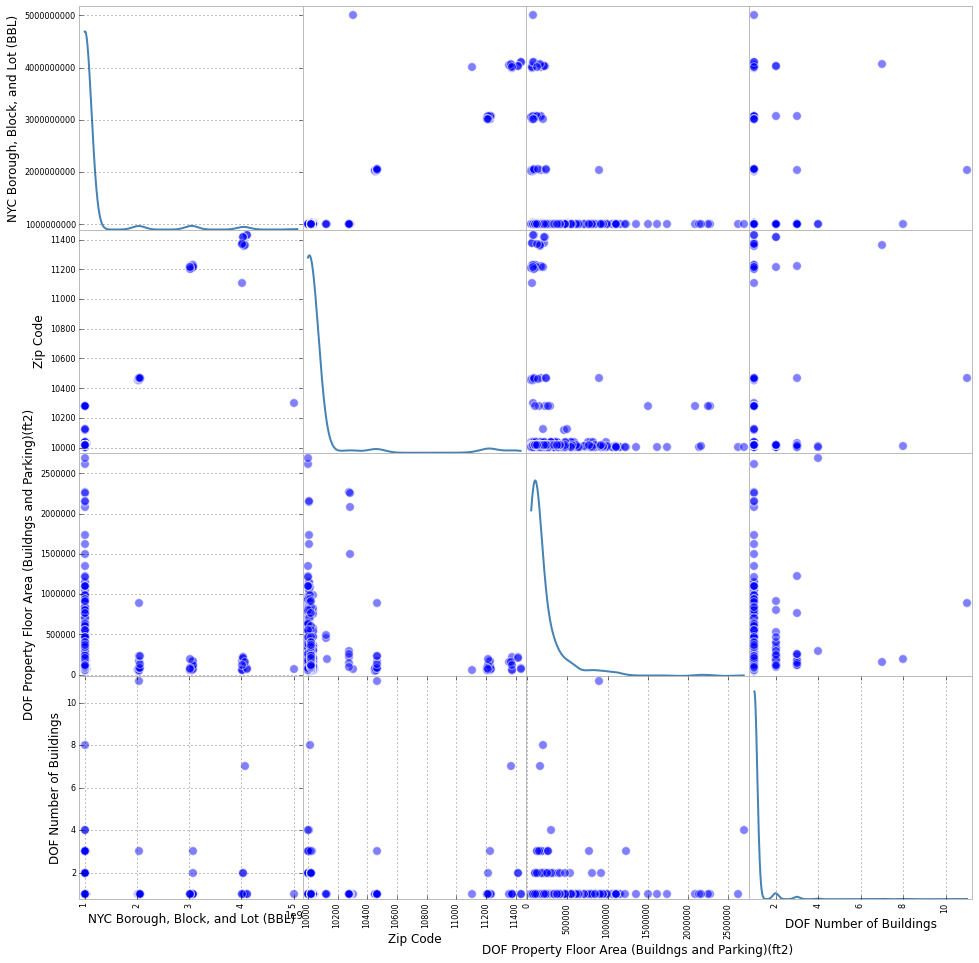

In [6]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16), diagonal='kde');

it will show me correlations between variables, but it will also show me what can and 
cannot be plotted trivially in my dataset! here only a few columns can be plotted: 
those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. 
The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg.       u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them. 

Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.  
this has to be done entry by entry: if you gve t a series you get error "cannot convert the series to <type 'float'>"

However you can pass it a whole array by using it in conjunction with
np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.


In [157]:
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')
nrg = nrg[pd.notnull(nrg['Site EUI(kBtu/ft2)'])]

In [158]:
print nrg['Site EUI(kBtu/ft2)'].astype(float).head()
print bsize.BBL.astype(float).head()


Record Number
16099    180.5
500       82.1
5017     137.7
5116     103.2
363       74.0
Name: Site EUI(kBtu/ft2), dtype: float64
0    1002760020
1    1002280022
2    1005900056
3    1005890030
4    1005310056
Name: BBL, dtype: float64


#TO MERGE THE DATASET WE NEED A COMMON COLUMN
here is where you want to merge the datasets. You need a common column: the building id BBL
However the name of this variable (column) in the Energy dataset is     'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!)

PHILIPP: actually we dont need that as there are left_on and right_on optional parameters

In [159]:
nrg['NYC Borough, Block, and Lot (BBL)'].head()

Record Number
16099    4084010096
500      1005050001
5017     1021420100
5116     1021750080
363      1003360005
Name: NYC Borough, Block, and Lot (BBL), dtype: float64

In [160]:
bsize.BBL.head()

0    1002760020
1    1002280022
2    1005900056
3    1005890030
4    1005310056
Name: BBL, dtype: float64

In [180]:
nrg = nrg.rename(columns={'NYC Borough, Block, and Lot (BBL)':'BBL'})

In [181]:
bblnrgdata = pd.merge(nrg, bsize, how='inner', on='BBL',copy=True)
print len(bblnrgdata)

832


In [182]:
bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'],errors='coerce')
bblnrgdata= bblnrgdata[pd.notnull(bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'])]

In [183]:
bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].head()

0    235370
1     64806
2     62839
3     98000
4    204417
Name: Reported Property Floor Area (Building(s)) (ft²), dtype: float64

once you have the dataframe with all the info you want, you want to plot 
Energy vs Number of Units in the Building. 
Remember: Energy TOTAL, not per sq ft...
Here you can choose what you think makes more sense for the number of units: all units, residential units...
make a 'natural' scale scatter plot first it will look really bad cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000.
perhaps zoom into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

In [184]:
bblnrgdata['nrg'] =bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)*bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

In [185]:
bblnrgdata[['nrg','Site EUI(kBtu/ft2)','Reported Property Floor Area (Building(s)) (ft²)']].head()

,nrg,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,19323877.0,82.1,235370
1,8923786.2,137.7,64806
2,6484984.8,103.2,62839
3,7252000.0,74.0,98000
4,26574210.0,130.0,204417


In [206]:
bblnrgdata_cut = bblnrgdata[(bblnrgdata.nrg>1000) & (bblnrgdata.nrg<1e11) & (bblnrgdata.UnitsTotal<600) & (bblnrgdata.UnitsTotal>10)]

print len(bblnrgdata)
print len(bblnrgdata_cut)

830
610


In [207]:
data = bblnrgdata_cut[['UnitsTotal','nrg']]
data.head(5)

,UnitsTotal,nrg
0,24,19323877.0
1,62,8923786.2
2,85,6484984.8
3,128,7252000.0
5,61,8313213.0


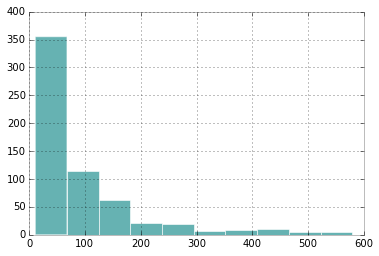

In [208]:
data.UnitsTotal.hist(color='teal',alpha=.6)

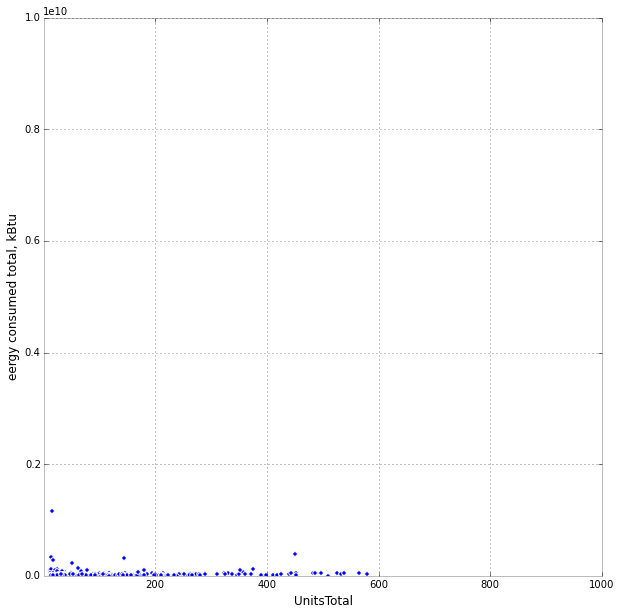

In [209]:
data.plot(x='UnitsTotal',y='nrg',kind='scatter',ylim=(1000,1e10), xlim=(1,1000),figsize=(10,10));
plt.ylabel('eergy consumed total, kBtu');

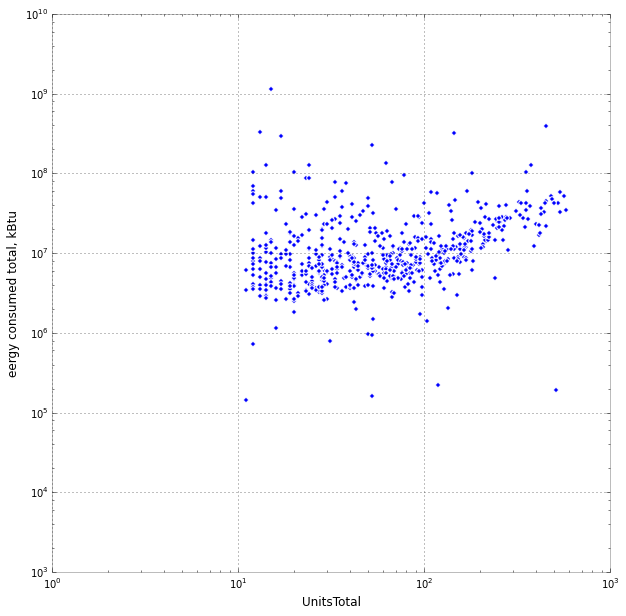

In [210]:
data.plot(x='UnitsTotal',y='nrg',kind='scatter', loglog=True, ylim=(1000,1e10), xlim=(1,1000), figsize=(10,10));
plt.ylabel('eergy consumed total, kBtu');

Now fit a line through the data. you can use whatever you want to do it: 
statsmodels, scipy, any other package, or write your own minimization of the residuals
## BUT REMEMBER: we see hints of a lienar relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:

In [220]:
import statsmodels.formula.api as smf

In [221]:
dt = pd.DataFrame({'Y':np.log1(data.nrg),
                  'X':np.log10(data.UnitsTotal)})

In [222]:
len(dt)

610

In [223]:
m1 = smf.ols('Y ~ X', dt, missing = 'drop').fit()

remember to choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which  variable has a 'sensible' distribution that allows you to fit a function to it: 
    you need your independent variable to span a large range, and to be spread somewhat evenly in the range, 
    rather than just clustered in a spot
    


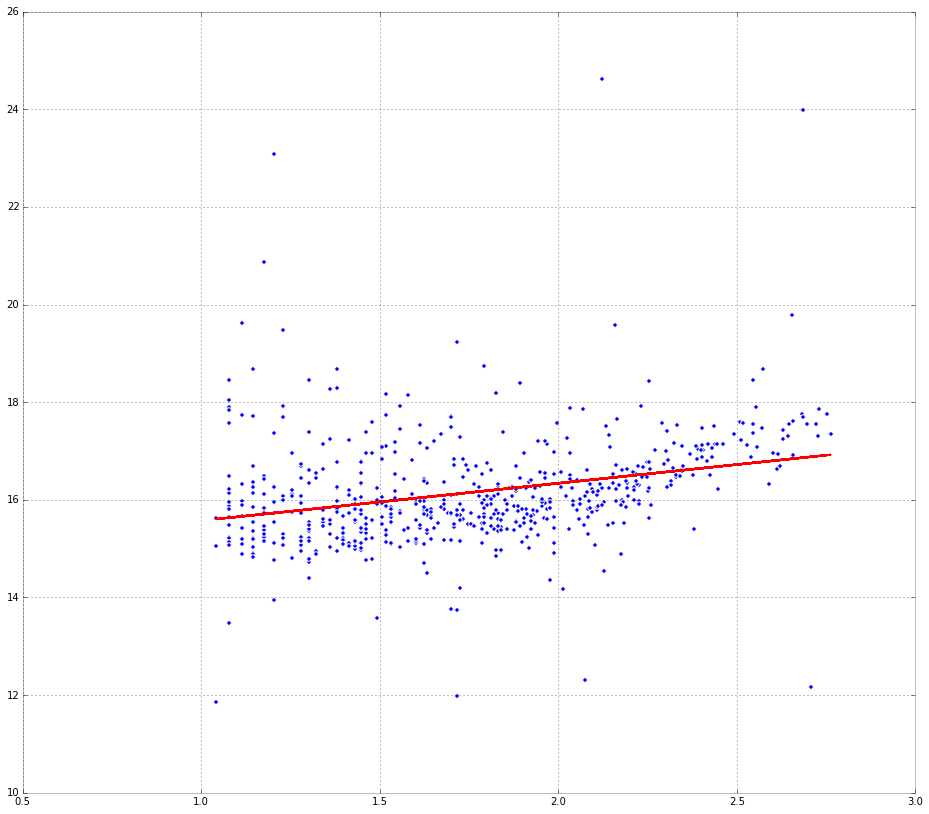

In [224]:
plt.figure(figsize=(16,14))
plt.scatter(dt.X,dt.Y)
plt.plot(dt.X,m1.predict(),color='r')

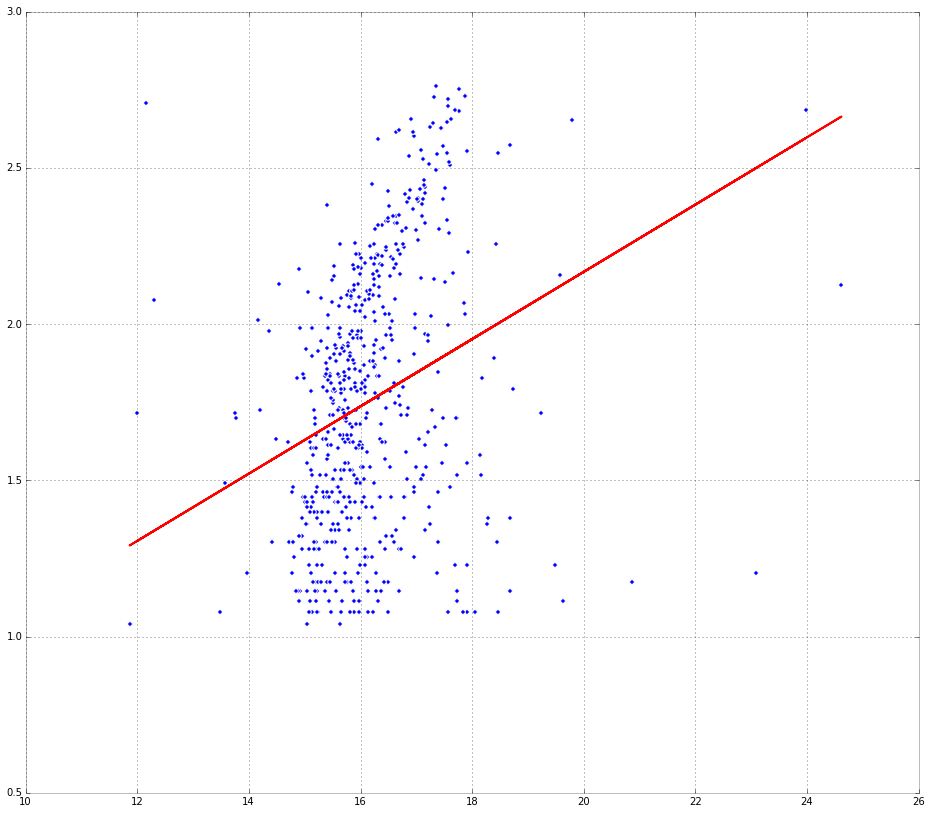

In [225]:
m2 = smf.ols('X ~ Y', dt, missing = 'drop').fit()

plt.figure(figsize=(16,14))
plt.scatter(dt.Y,dt.X)
plt.plot(dt.Y,m2.predict(),color='r')

try making a fit for energy vs units AND a fit for units vs energy. 
tell me which is better. 

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

In [226]:
print m1.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     54.60
Date:                Wed, 14 Oct 2015   Prob (F-statistic):           4.90e-13
Time:                        16:32:43   Log-Likelihood:                -915.34
No. Observations:                 610   AIC:                             1835.
Df Residuals:                     608   BIC:                             1844.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     14.8083      0.187     79.219      0.0

In [227]:
print m2.summary()

                            OLS Regression Results                            
Dep. Variable:                      X   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     54.60
Date:                Wed, 14 Oct 2015   Prob (F-statistic):           4.90e-13
Time:                        16:32:46   Log-Likelihood:                -316.77
No. Observations:                 610   AIC:                             637.5
Df Residuals:                     608   BIC:                             646.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0151      0.236      0.064      0.9

**Units better predict energy then the opposite. We can not use likelihood ratio test, though**

##now fit a second degree curve to it: a*x^2+b*x+c. 
that is still called a linear fir by the way, the "linear" definition refers to the PARAMETERS being linear, not to the variable!
you can use np.polyfit for example (an example showned in the other assignment notebook), with order 2 instead of 1,

np.polyfit(x, y, 2)

or statmodels.formula.api passing a formula like 

formula = 'y ~ 1 + x + I(x ^ 2.0)'

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     47.81
Date:                Wed, 14 Oct 2015   Prob (F-statistic):           5.24e-20
Time:                        16:38:50   Log-Likelihood:                -896.96
No. Observations:                 610   AIC:                             1800.
Df Residuals:                     607   BIC:                             1813.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      19.0288      0.711     26.771      

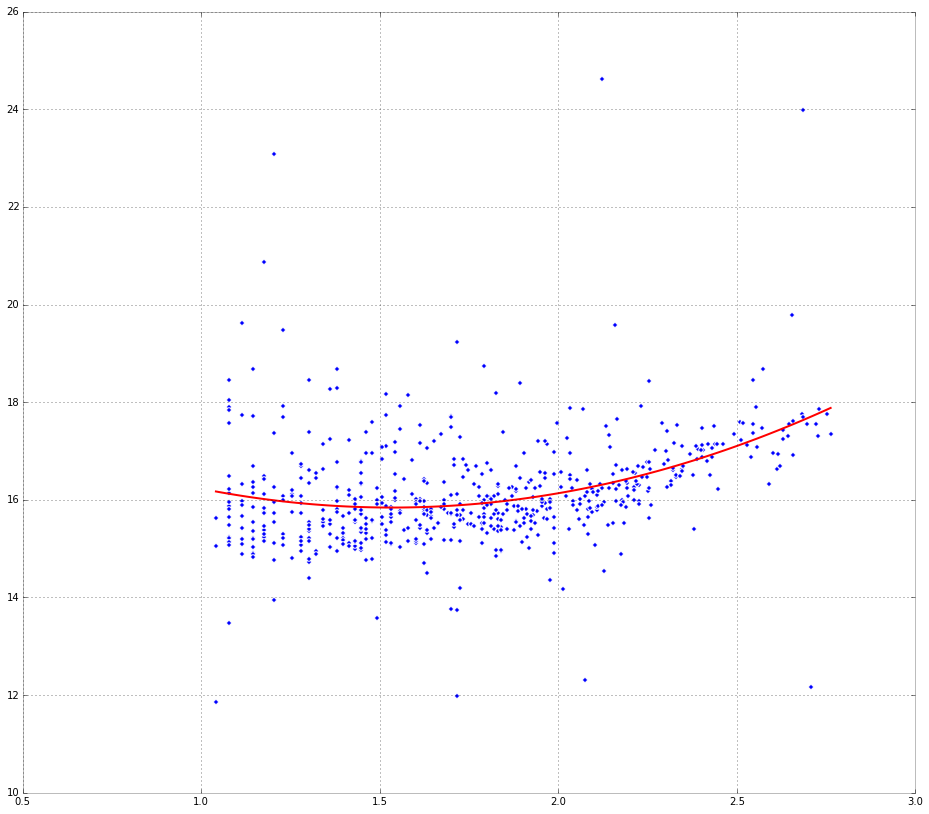

In [231]:
m3 = smf.ols('Y ~ 1+X+I(X**2.0)', data=dt).fit()

dx=  pd.DataFrame({'X': np.linspace(dt.X.min(), dt.X.max(), 100)})
plt.figure(figsize=(16,14))
plt.scatter(dt.X, dt.Y)
plot(dx,m3.predict(dx),'r')
print m3.summary()

**This model is way better, as adjusted R-squared is highter, but we still cant do likelyhood check as degree of freedom for the curve model is still 1 **

EXTRA CREDIT: 
    
use WLS the weighted sq fit instead of OLS. you need to give weights to your points: 
estimates of the errors. the easiest thing is the sqrt of the datapoint value.
if you want to be more sophisticated you can estimate the variance of your data
near each point and use that 

Lastly: do it by hand and create a function that minimizes the residuals: 
       
the residuals are the sum of the differences between data and model: 
in the case of a line fit model (and you can use your errors if you did the extra credit!)

sum(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2

where a and b are the parameters returned by the line fitter. 
for each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope

write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


for i,a in enumerate(A):

    for j,b in enumerate(B):
    
         Lsurface[i][j].....

this gives you a 2D array that represents your likelihood surface! what we do to find a good fit is find the minimum (lowest point) on this surface. 

you can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap"

but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface))
and see if it helps!
also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. do that with the keyword extent: 
pl.imshow(Lsurface, .... , extent = [minimum, and max of your y array, minimum, and max of your x array]...) (notice that the numbers are switched! make sure to verify which axis is the slope, which is the intercept)

In [23]:
##create the array
##[...]
##pl.figure(figsize=(10,10))
##pl.title ("log likelihood surface", fontsize = 22)
##pl.imshow(np.log(Lsurface), extent = ..., aspect=...)
##[...]
##pl.colorbar()

EXTRA CREDIT: get creative with the dataset! can you make an insigntful plot to show any structure in the data?
    
below is my silly attempt at that




In [274]:
data2 = bblnrgdata_cut

In [275]:
print len(data2)
# data2['YearBuilt'] = pd.to_numeric( data2[(data2.YearBuilt>1000)], errors='coerce')
# data2 = data2[pd.notnull(data2.YearBuilt)]
# print len(data2)

610


In [276]:
data2 = data2[data2['Site EUI(kBtu/ft2)']>0]

In [298]:
def ifAltered(x):
    if x:
        return True
    else:
        return False

data2['altered']=data2.YearAlter1.apply(ifAltered)
data2['altered'].value_counts()

True     343
False    267
Name: altered, dtype: int64

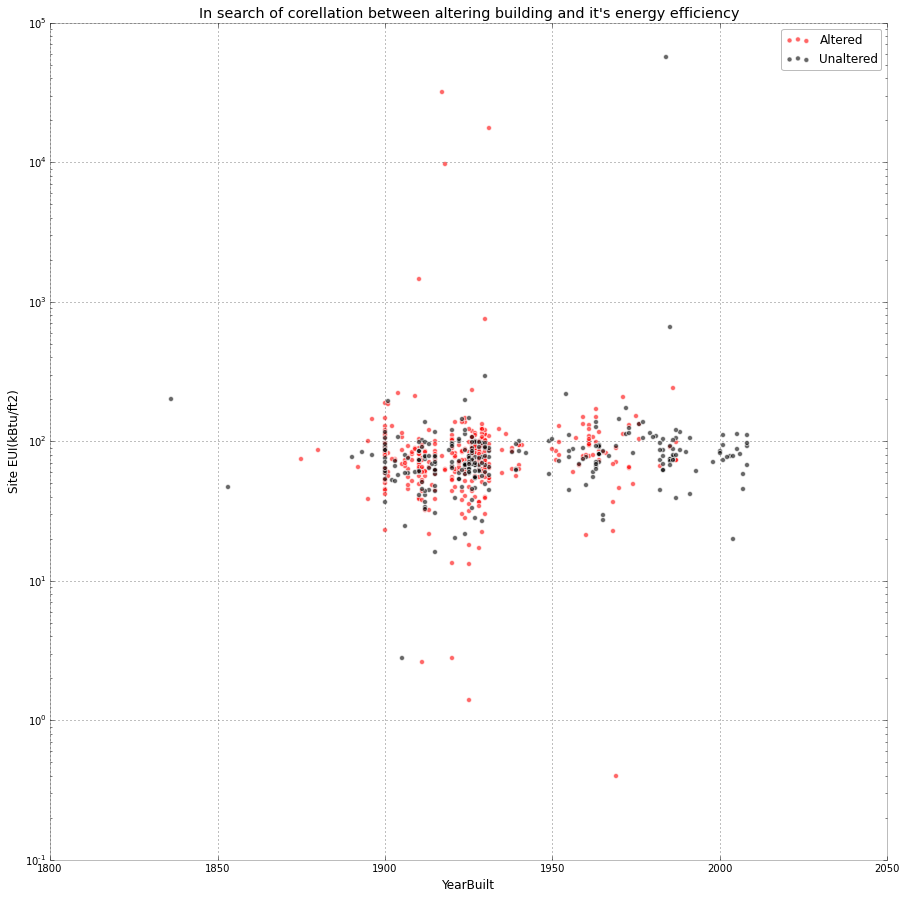

In [310]:

ax = data2[data2['altered']].plot(kind='scatter',x='YearBuilt',alpha=.6,s=25, y='Site EUI(kBtu/ft2)',color='r', logy=True , figsize=(15,15), label='Altered')
data2[~data2['altered']].plot(kind='scatter',x='YearBuilt',alpha=.6,s=25, y='Site EUI(kBtu/ft2)',color='k', logy=True , figsize=(15,15), ax=ax, label='Unaltered')

plt.title("In search of corellation between altering building and it's energy efficiency")
plt.legend(numpoints=1)


/Users/fbianco/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


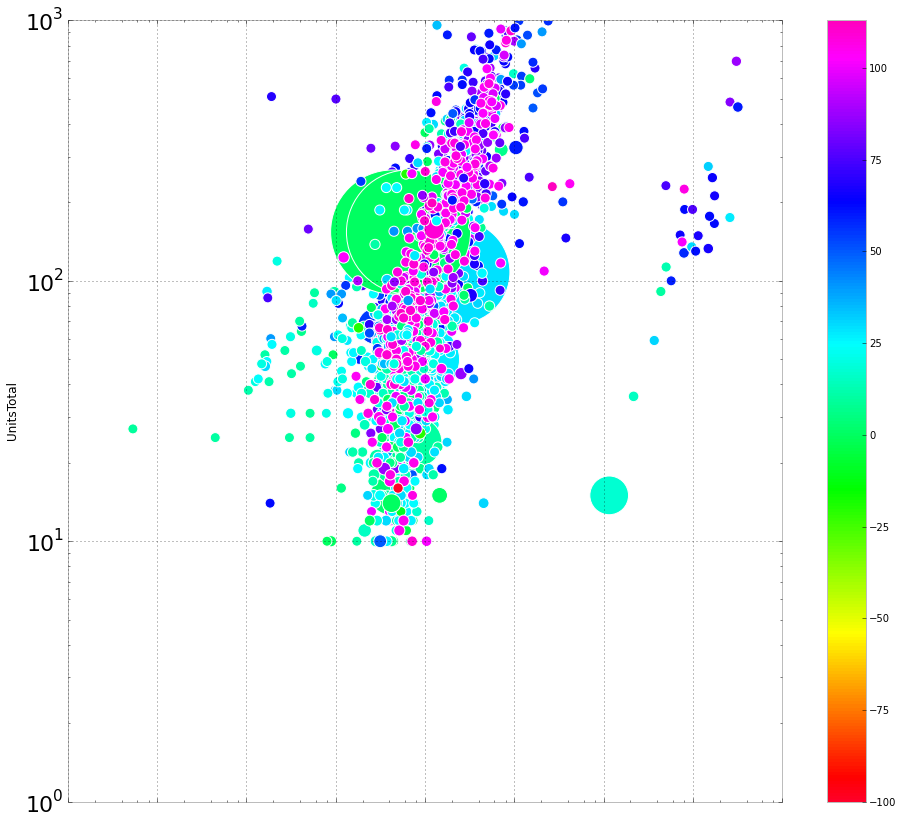

In [27]:
bblnrgdatacut['YearBuilt']=1800

bblnrgdatacut.plot(kind='scatter',x='nrg',y='UnitsTotal', fontsize=22, colormap='gist_rainbow', alpha = 1, marker='o',  figsize=(16, 14), loglog=True,  xlim=(1000,1e11), ylim=(1,1000), c=bblnrgdatacut['YearBuilt']-1900, s=bblnrgdatacut['UnitsTotal']/bblnrgdatacut['UnitsRes']*100)